# **import libraries&EDA**

In [103]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import spacy
import re 
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud as we
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

In [104]:
sns.set_style('darkgrid')

In [105]:
df=pd.read_csv(r"D:\NLP work shop\twitter_training.csv")
df.columns = ['id', 'topic', 'sentiment', 'tweet']

In [106]:
df.head()

,id,topic,sentiment,tweet
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [107]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         74681 non-null  int64 
 1   topic      74681 non-null  object
 2   sentiment  74681 non-null  object
 3   tweet      73995 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [108]:
df.dropna(inplace=True)

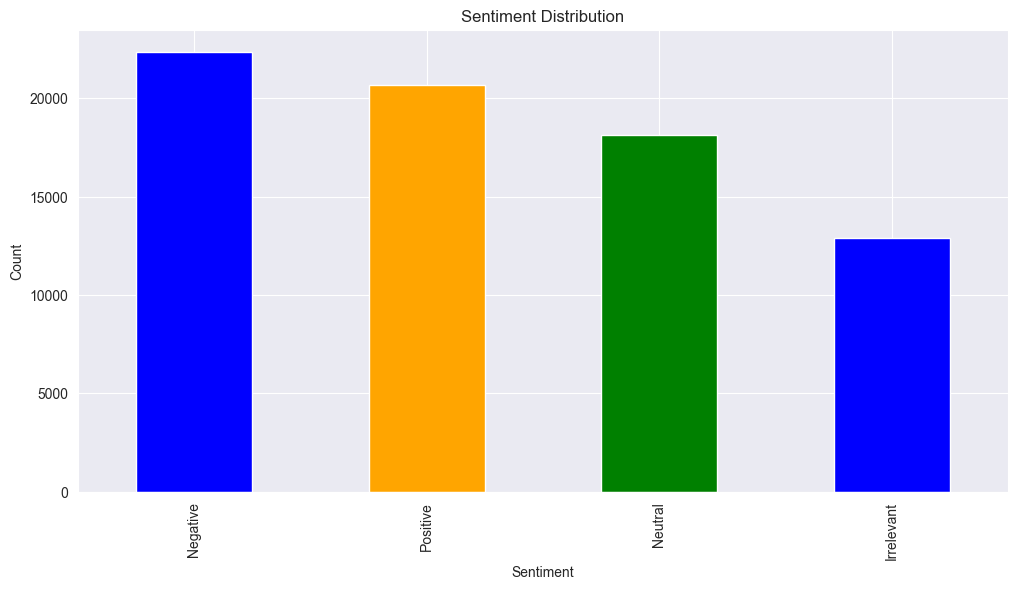

In [109]:
plt.figure(figsize=(12,6))
df['sentiment'].value_counts().plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

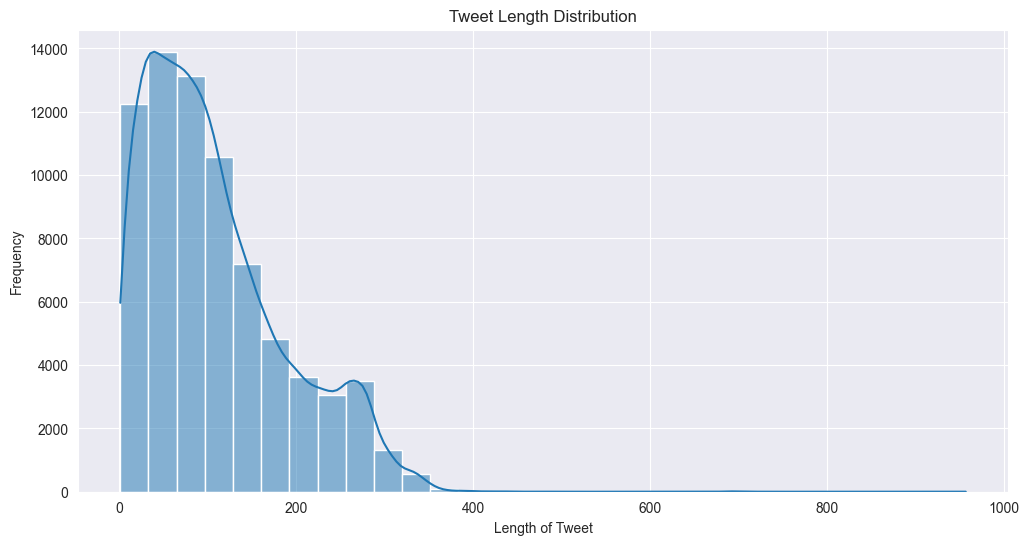

In [110]:
df['len_text']=df['tweet'].apply(len)
plt.figure(figsize=(12,6))
sns.histplot(df['len_text'], bins=30, kde=True)
plt.title('Tweet Length Distribution')
plt.xlabel('Length of Tweet')
plt.ylabel('Frequency')
plt.show()

In [111]:
df['len_text'].describe()

count    73995.000000
mean       108.784404
std         79.524485
min          1.000000
25%         47.000000
50%         91.000000
75%        153.000000
max        957.000000
Name: len_text, dtype: float64

# **Clean&preprocesing**

In [112]:
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+|\#','', text)
    text = re.sub(r'[^A-Za-z0-9\s]+', '', text)
    text = text.lower()
    return text

df['tweet'] = df['tweet'].apply(clean_text)
df.head()

,id,topic,sentiment,tweet,len_text
0,2401,Borderlands,Positive,i am coming to the borders and i will kill you...,51
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you all,50
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,51
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,57
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,53


In [113]:
nlp = spacy.load('en_core_web_sm')
def preprocess_spacy(text):
    if not isinstance(text, str):
        return ""
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc if not token.is_stop])

df['tweet'] = df['tweet'].apply(preprocess_spacy)
df.head()

,id,topic,sentiment,tweet,len_text
0,2401,Borderlands,Positive,come border kill,51
1,2401,Borderlands,Positive,m get borderland kill,50
2,2401,Borderlands,Positive,m come borderland murder,51
3,2401,Borderlands,Positive,m get borderland 2 murder,57
4,2401,Borderlands,Positive,m get borderland murder,53


In [114]:
df.loc[4, 'tweet']

'm get borderland murder'

In [115]:
le = LabelEncoder()
df['sentiment'] = le.fit_transform(df['sentiment'])

In [116]:
X=df['tweet']
y=df['sentiment']

In [117]:
max_len=200
df=df[df['len_text']<=max_len]

In [118]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training set size: 59196
Validation set size: 14799


In [119]:
tfidf_vectorizer = TfidfVectorizer(min_df=2, max_df=0.8, ngram_range=(1,3))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

In [120]:
from sklearn.linear_model import LogisticRegression

In [125]:
model = LogisticRegression(random_state=42,max_iter=1000,class_weight='balanced')
model.fit(X_train_tfidf, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


Validation Accuracy: 0.8671


Text(0.5, 1.0, 'Confusion Matrix')

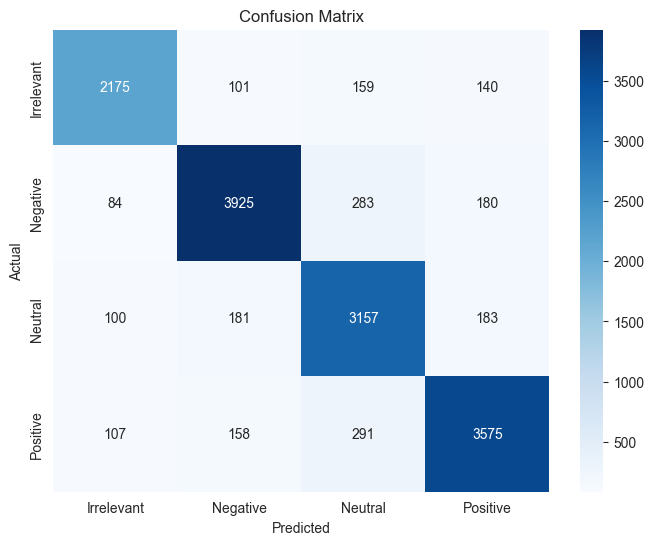

In [126]:
y_pred = model.predict(X_val_tfidf)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")
conf_matrix = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

In [127]:
print(classification_report(y_val, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

  Irrelevant       0.88      0.84      0.86      2575
    Negative       0.90      0.88      0.89      4472
     Neutral       0.81      0.87      0.84      3621
    Positive       0.88      0.87      0.87      4131

    accuracy                           0.87     14799
   macro avg       0.87      0.86      0.87     14799
weighted avg       0.87      0.87      0.87     14799



In [128]:
df_test=pd.read_csv(r"D:\NLP work shop\twitter_test.csv")
df_test.columns = ['id', 'topic','sentiment', 'tweet']
df_test['tweet'] = df_test['tweet'].apply(clean_text)
df_test['tweet'] = df_test['tweet'].apply(preprocess_spacy)
df_test['sentiment'] = le.transform(df_test['sentiment'])
X_test_tfidf = tfidf_vectorizer.transform(df_test['tweet'])
test_pred = model.predict(X_test_tfidf)
print(classification_report(df_test['sentiment'], test_pred, target_names=le.classes_))

              precision    recall  f1-score   support

  Irrelevant       0.95      0.96      0.96       171
    Negative       0.98      0.97      0.97       266
     Neutral       0.98      0.98      0.98       285
    Positive       0.96      0.96      0.96       277

    accuracy                           0.97       999
   macro avg       0.97      0.97      0.97       999
weighted avg       0.97      0.97      0.97       999

